In [1]:
import logging

import anndata
import numpy as np
import pandas as pd
import plotnine as p
import matplotlib.pyplot as plt
import scvi
from scvi.model.utils import mde
import scHPL
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

Global seed set to 0


In [2]:
alladata = anndata.read('GSE214695.h5ad')

In [3]:
adata = alladata[alladata.obs.sample(10_000).index].copy()

In [4]:
scvi.model.SCVI.setup_anndata(
    adata,
    batch_key = 'sample_name',
    size_factor_key = 'total_counts'
)

model = scvi.model.SCVI(
    adata,
    gene_likelihood = 'nb'
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
model.train(40)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 40/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:02<00:00,  1.53s/it, loss=4.08e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:02<00:00,  1.55s/it, loss=4.08e+03, v_num=1]


In [6]:
scdl_ = model._make_data_loader(adata, batch_size = 16)

n_within = 0
total = 0
negative_examples = []
for tensors in tqdm(scdl_):
    inference = model.module.inference(**model.module._get_inference_input(tensors))
    qz = inference['qz']
    inference['z'] = qz.sample_n(200).detach()

    generative = model.module.generative(**model.module._get_generative_input(tensors, inference))
    px = generative['px']
    px_sample = px.sample().detach()

    xt = tensors['X'].cuda().detach()

    above = (px_sample.quantile(0.05, 0) <= xt).detach()
    below = (xt <= px_sample.quantile(0.95, 0)).detach()
    n_within += (above & below).sum()

    total += xt.shape[0] * xt.shape[1]
    
    break

  0%|                                                                                                                                                        | 0/625 [00:00<?, ?it/s]


In [11]:
((~above) ^ (~below)).sum()

tensor(2492, device='cuda:0')

In [12]:
n_within

tensor(534116, device='cuda:0')

In [39]:
expression_levels = (
    pd.DataFrame(px.mu.mean(0).detach().cpu())
    .reset_index()
    .melt(id_vars = 'index')
    .rename(columns = {'value': 'expression'})
#     .sort_values('value', ascending = False)
)

expression_levels

,index,variable,expression
0,0,0,0.000011
1,1,0,0.000111
2,2,0,0.000256
3,3,0,0.000703
4,4,0,0.000190
...,...,...,...
536603,11,33537,0.000861
536604,12,33537,0.000630
536605,13,33537,0.000585
536606,14,33537,0.000719


In [40]:
outside_interval = (
    pd.DataFrame(((~above) ^ (~below)).cpu())
    .reset_index()
    .melt(id_vars = 'index')
    .rename(columns = {'value': 'outside_interval'})
)

outside_interval

,index,variable,outside_interval
0,0,0,False
1,1,0,False
2,2,0,False
3,3,0,False
4,4,0,False
...,...,...,...
536603,11,33537,False
536604,12,33537,False
536605,13,33537,False
536606,14,33537,False


In [42]:
expression_levels.merge(outside_interval).query('outside_interval').sort_values('expression', ascending = False)

,index,variable,expression,outside_interval
380207,15,23762,5621.777832,True
518367,15,32397,3876.460205,True
64418,2,4026,3273.814941,True
518364,12,32397,2931.102051,True
380196,4,23762,2160.481445,True
...,...,...,...,...
231565,13,14472,0.000554,True
38055,7,2378,0.000472,True
294671,15,18416,0.000418,True
160430,14,10026,0.000410,True


In [43]:
expression_levels.merge(outside_interval).query('outside_interval == False').sort_values('expression', ascending = False)

,index,variable,expression,outside_interval
64431,15,4026,2.984557e+04,False
64428,12,4026,2.583505e+04,False
64430,14,4026,1.559868e+04,False
64420,4,4026,1.237838e+04,False
64417,1,4026,7.884078e+03,False
...,...,...,...,...
242026,10,15126,8.400749e-07,False
50282,10,3142,8.322720e-07,False
144938,10,9058,8.153191e-07,False
352314,10,22019,8.104284e-07,False


In [45]:
px_sample.shape

torch.Size([200, 16, 33538])

In [92]:
px_sample[:, 15, 23762]

tensor([6.2040e+03, 7.1150e+03, 5.4020e+03, 1.2054e+04, 6.9190e+03, 7.1590e+03,
        9.3600e+02, 3.8000e+02, 5.4250e+03, 8.3050e+03, 6.3970e+03, 5.2530e+03,
        6.1270e+03, 3.2170e+03, 8.7370e+03, 1.4176e+04, 1.0870e+04, 4.6530e+03,
        1.5270e+03, 2.5590e+03, 4.8480e+03, 1.4150e+03, 5.5050e+03, 8.1010e+03,
        1.4890e+03, 7.3880e+03, 3.0830e+03, 7.4720e+03, 9.1080e+03, 3.2080e+03,
        1.9210e+03, 2.4820e+03, 6.8800e+02, 1.8650e+03, 1.4816e+04, 1.1400e+03,
        2.6040e+03, 2.5120e+03, 1.7329e+04, 4.8630e+03, 6.2500e+02, 6.9260e+03,
        4.4600e+03, 7.1900e+02, 3.5850e+03, 9.1400e+03, 2.0643e+04, 2.1090e+03,
        4.4560e+03, 5.9780e+03, 1.7308e+04, 6.1820e+03, 1.2088e+04, 2.4320e+03,
        3.4130e+03, 9.1590e+03, 1.3522e+04, 4.7330e+03, 3.1210e+03, 6.5650e+03,
        4.2070e+03, 1.0200e+02, 1.1248e+04, 2.6046e+04, 1.3310e+03, 5.5380e+03,
        2.0550e+03, 6.6170e+03, 2.1424e+04, 7.3520e+03, 5.2770e+03, 3.2000e+01,
        7.4880e+03, 4.6290e+03, 8.7380e+

In [51]:
tensors['X'][15, 23762]

tensor(14.)

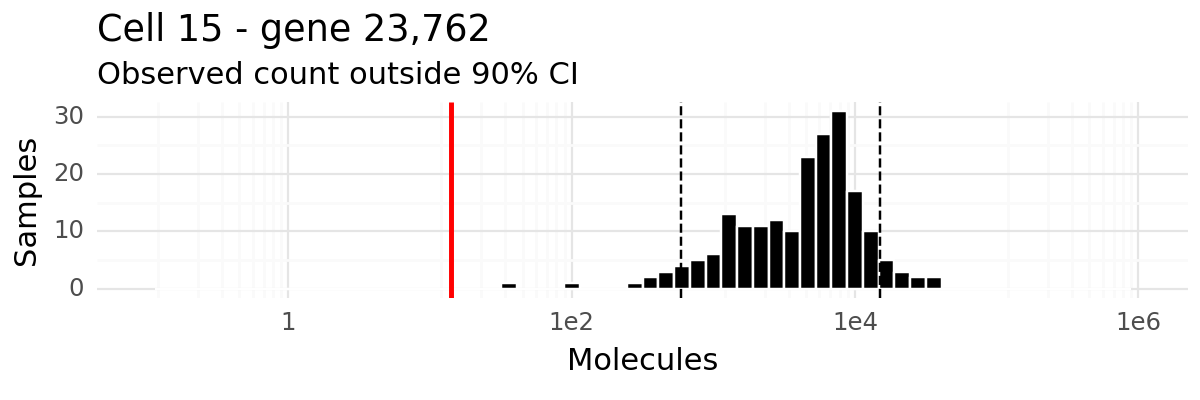

In [124]:
tmp_ = pd.Series(px_sample[:, 15, 23762].cpu()).rename('count').reset_index()

p.options.figure_size = 6, 2

p_ = (
    p.ggplot(p.aes(x = 'count'), tmp_)
    + p.geom_histogram(bins = 64, fill = 'k', color = 'white')
    + p.geom_vline(xintercept = tmp_['count'].quantile(0.05), linetype = 'dashed')
    + p.geom_vline(xintercept = tmp_['count'].quantile(0.95), linetype = 'dashed')
    + p.geom_vline(xintercept = tensors['X'][15, 23762], color = 'red', size = 1)
    + p.scale_x_log10(limits = [0.1, 1e6])
    + p.theme_minimal()
    + p.labs(
        title = 'Cell 15 - gene 23,762',
        subtitle = 'Observed count outside 90% CI',
        x = 'Molecules',
        y = 'Samples'
    )
)

p_.save('fig1.png', dpi = 300)

print(p_)

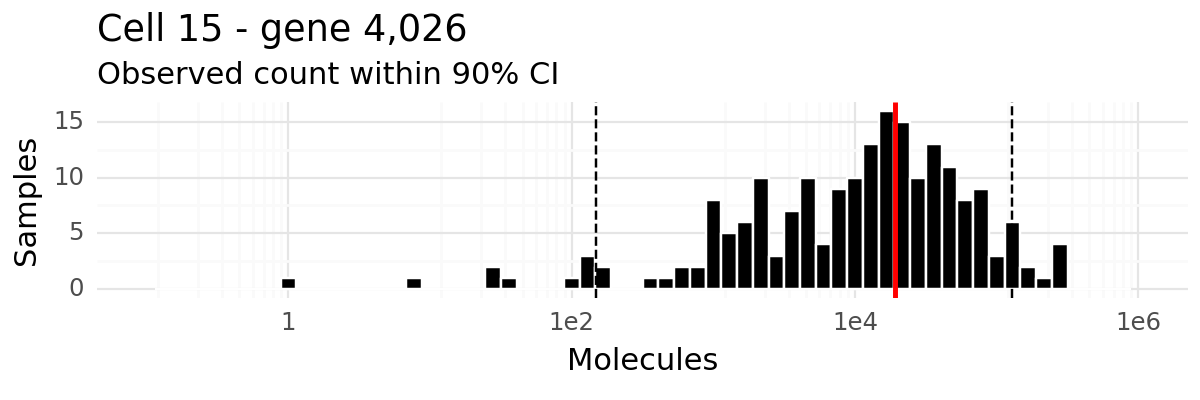

In [125]:
tmp_ = pd.Series(px_sample[:, 15, 4026].cpu()).rename('count').reset_index()

p.options.figure_size = 6, 2

p_ = (
    p.ggplot(p.aes(x = 'count'), tmp_)
    + p.geom_histogram(bins = 64, fill = 'k', color = 'w')
    + p.geom_vline(xintercept = tmp_['count'].quantile(0.05), linetype = 'dashed')
    + p.geom_vline(xintercept = tmp_['count'].quantile(0.95), linetype = 'dashed')
    + p.geom_vline(xintercept = tensors['X'][15, 4026], color = 'red', size = 1)
    + p.scale_x_log10(limits = [0.1, 1e6])
    + p.theme_minimal()
    + p.labs(
        title = 'Cell 15 - gene 4,026',
        subtitle = 'Observed count within 90% CI',
        x = 'Molecules',
        y = 'Samples'
    )
)

p_.save('fig2.png', dpi = 300)

print(p_)

In [126]:
scdl_ = model._make_data_loader(adata, batch_size = 16)

n_within = 0
total = 0
for tensors in tqdm(scdl_):
    inference = model.module.inference(**model.module._get_inference_input(tensors))
    qz = inference['qz']
    inference['z'] = qz.sample_n(200).detach()

    generative = model.module.generative(**model.module._get_generative_input(tensors, inference))
    px = generative['px']
    px_sample = px.sample().detach()

    xt = tensors['X'].cuda().detach()

    above = (px_sample.quantile(0.05, 0) <= xt).detach()
    below = (xt <= px_sample.quantile(0.95, 0)).detach()
    n_within += (above & below).sum()

    total += xt.shape[0] * xt.shape[1]
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [02:43<00:00,  3.83it/s]


In [134]:
n_within.cpu().numpy() // 1, total

(333611976, 335380000)

In [131]:
n_within.cpu().numpy() / total

0.9947282962609577